In [1]:
import torch
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from fuzzywuzzy import fuzz
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/deepankkartikey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/deepankkartikey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/deepankkartikey/Desktop/uOttawa/Winter-2022/CSI-5180/assignment-3/SemEval-PIT2015-github/env/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# read data and setup columns
train_df = pd.read_csv("data/train.data", 
                     sep="\t",
                     names=["Topic_Id","Topic_Names","Sent_1","Sent_2","Label","Sent_1_tag","Sent_2_tag"])
dev_df = pd.read_csv("data/dev.data", 
                     sep="\t",
                     names=["Topic_Id","Topic_Names","Sent_1","Sent_2","Label","Sent_1_tag","Sent_2_tag"])
test_df = pd.read_csv("data/test.data", 
                     sep="\t",
                     names=["Topic_Id","Topic_Names","Sent_1","Sent_2","Label","Sent_1_tag","Sent_2_tag"])

In [3]:
dev_df.head()

,Topic_Id,Topic_Names,Sent_1,Sent_2,Label,Sent_1_tag,Sent_2_tag
0,17,A Walk To Remember,A Walk to Remember is the definition of true love,A Walk to Remember is on and Im in town and Im...,"(1, 4)",A/O/DT/B-NP/O Walk/O/NN/I-NP/O to/O/TO/B-VP/O ...,A/O/DT/B-NP/O Walk/O/NN/I-NP/O to/O/TO/B-VP/O ...
1,17,A Walk To Remember,A Walk to Remember is the definition of true love,A Walk to Remember is the cutest thing,"(3, 2)",A/O/DT/B-NP/O Walk/O/NN/I-NP/O to/O/TO/B-VP/O ...,A/O/DT/B-NP/O Walk/O/NN/I-NP/O to/O/TO/B-VP/O ...
2,17,A Walk To Remember,A Walk to Remember is the definition of true love,A walk to remember is on ABC family youre welcome,"(1, 4)",A/O/DT/B-NP/O Walk/O/NN/I-NP/O to/O/TO/B-VP/O ...,A/O/DT/B-NP/O walk/O/NN/I-NP/O to/O/TO/B-VP/O ...
3,17,A Walk To Remember,A Walk to Remember is the definition of true love,A walk to remember is so amazing and inspiring,"(3, 2)",A/O/DT/B-NP/O Walk/O/NN/I-NP/O to/O/TO/B-VP/O ...,A/O/DT/B-NP/O walk/O/NN/I-NP/O to/O/TO/B-VP/O ...
4,17,A Walk To Remember,A Walk to Remember is the definition of true love,BUT GUYS ITS ON MY FAVE PART OF A WALK TO REME...,"(1, 4)",A/O/DT/B-NP/O Walk/O/NN/I-NP/O to/O/TO/B-VP/O ...,BUT/O/CC/O/O GUYS/O/VBP/B-VP/B-EVENT ITS/O/PRP...


In [4]:
dev_copy = dev_df.copy()

In [5]:
dev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4727 entries, 0 to 4726
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Topic_Id     4727 non-null   int64 
 1   Topic_Names  4727 non-null   object
 2   Sent_1       4727 non-null   object
 3   Sent_2       4727 non-null   object
 4   Label        4727 non-null   object
 5   Sent_1_tag   4727 non-null   object
 6   Sent_2_tag   4727 non-null   object
dtypes: int64(1), object(6)
memory usage: 258.6+ KB


In [6]:
# Labels column
dev_df['Label']

0       (1, 4)
1       (3, 2)
2       (1, 4)
3       (3, 2)
4       (1, 4)
         ...  
4722    (0, 5)
4723    (1, 4)
4724    (0, 5)
4725    (0, 5)
4726    (0, 5)
Name: Label, Length: 4727, dtype: object

In [7]:
# Sample 10% records from training data
dev_df = dev_df.sample(frac = 0.1, random_state = 42)

In [8]:
dev_df.shape

(473, 7)

In [9]:
dev_df.head()

,Topic_Id,Topic_Names,Sent_1,Sent_2,Label,Sent_1_tag,Sent_2_tag
3965,1422,Ryu,Ryu is just something else,and that makes it 8 whiffs for Ryu,"(1, 4)",Ryu/O/NNP/B-NP/O is/O/VBZ/B-VP/O just/O/RB/B-N...,and/O/NNS/O/O that/O/WDT/B-NP/O makes/O/VBZ/B-...
2917,912,Kris Kross,Just read about Mac Daddy Chris Kelly of Kris ...,Bout to put my clothes on backwards in remembr...,"(2, 3)",Just/O/RB/B-ADVP/O read/O/VBN/B-VP/B-EVENT abo...,Bout/O/NN/B-NP/O to/O/TO/B-VP/O put/O/VB/I-VP/...
1741,641,Harding,Way to go Josh Harding,I feel bad for Josh Harding played a great game,"(3, 2)",Way/O/NN/B-NP/O to/O/TO/B-VP/O go/O/VB/I-VP/B-...,I/O/PRP/B-NP/O feel/O/VBP/B-VP/B-EVENT bad/O/J...
2978,913,Kriss Kross,damn Chris Kelly of Kriss Kross at 34,Damn its sad to hear about Chris Kelly from Kr...,"(4, 1)",damn/O/UH/B-INTJ/O Chris/B-person/NNP/B-NP/O K...,Damn/O/RB/B-ADVP/O its/O/PRP/B-NP/O sad/O/JJ/B...
1498,503,Facebook,I posted 6 photos on Facebook in the album Zum...,How to end a group chat on facebook,"(0, 5)",I/O/PRP/B-NP/O posted/O/VBD/B-VP/B-EVENT 6/O/C...,How/O/WRB/B-ADVP/O to/O/TO/B-VP/O end/O/VB/I-V...


In [10]:
dev_df["Label"].value_counts()

(0, 5)    176
(1, 4)     91
(3, 2)     63
(2, 3)     58
(4, 1)     54
(5, 0)     31
Name: Label, dtype: int64

In [11]:
# Tranform labels of scores to Boolean values

def transform_labels(dataset):
    label = []
    for index, row in dataset.iterrows():
        if row["Label"] in ["(3, 2)","(4, 1)","(5, 0)"]:
            label.append(True)
        else:
            label.append(False)    
    dataset["Label"] = label
    return dataset

In [12]:
dev_df = transform_labels(dataset=dev_df)

In [13]:
dev_df.head()

,Topic_Id,Topic_Names,Sent_1,Sent_2,Label,Sent_1_tag,Sent_2_tag
3965,1422,Ryu,Ryu is just something else,and that makes it 8 whiffs for Ryu,False,Ryu/O/NNP/B-NP/O is/O/VBZ/B-VP/O just/O/RB/B-N...,and/O/NNS/O/O that/O/WDT/B-NP/O makes/O/VBZ/B-...
2917,912,Kris Kross,Just read about Mac Daddy Chris Kelly of Kris ...,Bout to put my clothes on backwards in remembr...,False,Just/O/RB/B-ADVP/O read/O/VBN/B-VP/B-EVENT abo...,Bout/O/NN/B-NP/O to/O/TO/B-VP/O put/O/VB/I-VP/...
1741,641,Harding,Way to go Josh Harding,I feel bad for Josh Harding played a great game,True,Way/O/NN/B-NP/O to/O/TO/B-VP/O go/O/VB/I-VP/B-...,I/O/PRP/B-NP/O feel/O/VBP/B-VP/B-EVENT bad/O/J...
2978,913,Kriss Kross,damn Chris Kelly of Kriss Kross at 34,Damn its sad to hear about Chris Kelly from Kr...,True,damn/O/UH/B-INTJ/O Chris/B-person/NNP/B-NP/O K...,Damn/O/RB/B-ADVP/O its/O/PRP/B-NP/O sad/O/JJ/B...
1498,503,Facebook,I posted 6 photos on Facebook in the album Zum...,How to end a group chat on facebook,False,I/O/PRP/B-NP/O posted/O/VBD/B-VP/B-EVENT 6/O/C...,How/O/WRB/B-ADVP/O to/O/TO/B-VP/O end/O/VB/I-V...


In [14]:
dev_df["Label"].value_counts()

False    325
True     148
Name: Label, dtype: int64

In [15]:
# Algorithm-1 - Cosine Similarity
# Program to measure the similarity between
# two sentences using cosine similarity.

def get_cosine_similarity(string1="I can listen to pandora again yay", string2="My Pandora time out is over"):
    # tokenize all words of both sentences
    X_list = word_tokenize(string1.lower())
    Y_list = word_tokenize(string2.lower())

    # sw contains the list of stopwords
    sw = stopwords.words('english')
    l1 =[];l2 =[]

    # remove stop words from the string
    X_set = {w for w in X_list if not w in sw}
    Y_set = {w for w in Y_list if not w in sw}

    # form a set containing keywords of both strings to create similarity vector
    rvector = X_set.union(Y_set)
    for w in rvector:
        if w in X_set: 
            l1.append(1) 
        else: 
            l1.append(0)
        if w in Y_set: 
            l2.append(1)
        else: 
            l2.append(0)
    
    # print as dataframe
    # data = [l1,l2]
    # display(pd.DataFrame(data, columns = rvector))
    c = 0

    # cosine formula
    for i in range(len(rvector)):
        c+= l1[i]*l2[i]
    cosine = c / float((sum(l1)*sum(l2))**0.5)
    cosine = float("{:.2f}".format(cosine))
    return cosine
    #print("similarity: ", cosine)


In [16]:
# get_cosine_similarity()

In [17]:
# Algorithm-1: BERT IMPL

def bert_impl(string_1,string_2):
    model_name = "bert-base-cased-finetuned-mrpc"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    tokens = tokenizer.encode_plus(string_1, string_2, return_tensors="pt")
    classification_logits = model(**tokens)[0]
    results = torch.softmax(classification_logits, dim=1).tolist()[0]

    classes = ["not paraphrase", "is paraphrase"]
    for i in range(len(classes)):
        print(f"{classes[i]}: {round(results[i] * 100):.2f}%")
        

In [18]:
cosine_similarities = []
for index,row in dev_df.iterrows():
    cosine_similarities.append(get_cosine_similarity(row["Sent_1"], row["Sent_2"]))

dev_df["Cosine_Similarities"] = cosine_similarities
dev_df["Algo_1"] = dev_df["Cosine_Similarities"]>0.7


In [19]:
dev_df.head()

,Topic_Id,Topic_Names,Sent_1,Sent_2,Label,Sent_1_tag,Sent_2_tag,Cosine_Similarities,Algo_1
3965,1422,Ryu,Ryu is just something else,and that makes it 8 whiffs for Ryu,False,Ryu/O/NNP/B-NP/O is/O/VBZ/B-VP/O just/O/RB/B-N...,and/O/NNS/O/O that/O/WDT/B-NP/O makes/O/VBZ/B-...,0.29,False
2917,912,Kris Kross,Just read about Mac Daddy Chris Kelly of Kris ...,Bout to put my clothes on backwards in remembr...,False,Just/O/RB/B-ADVP/O read/O/VBN/B-VP/B-EVENT abo...,Bout/O/NN/B-NP/O to/O/TO/B-VP/O put/O/VB/I-VP/...,0.50,False
1741,641,Harding,Way to go Josh Harding,I feel bad for Josh Harding played a great game,True,Way/O/NN/B-NP/O to/O/TO/B-VP/O go/O/VB/I-VP/B-...,I/O/PRP/B-NP/O feel/O/VBP/B-VP/B-EVENT bad/O/J...,0.38,False
2978,913,Kriss Kross,damn Chris Kelly of Kriss Kross at 34,Damn its sad to hear about Chris Kelly from Kr...,True,damn/O/UH/B-INTJ/O Chris/B-person/NNP/B-NP/O K...,Damn/O/RB/B-ADVP/O its/O/PRP/B-NP/O sad/O/JJ/B...,0.82,True
1498,503,Facebook,I posted 6 photos on Facebook in the album Zum...,How to end a group chat on facebook,False,I/O/PRP/B-NP/O posted/O/VBD/B-VP/B-EVENT 6/O/C...,How/O/WRB/B-ADVP/O to/O/TO/B-VP/O end/O/VB/I-V...,0.20,False


In [20]:
# Plot confusion matrix

def plot_conf_mat(y_test, y_preds):
    """
    y_test: test labels
    y_preds: predicted labels
    """
    sns.set(font_scale=1.5)
    conf_mat = confusion_matrix(y_test, y_preds)
    sns.heatmap(conf_mat,
                annot=True,
                cmap=None,
                fmt='.1f')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')

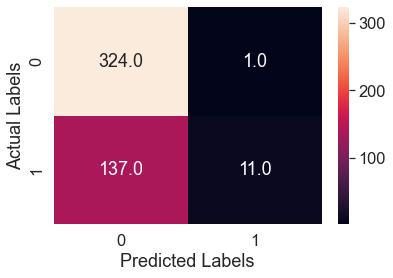

In [21]:
# Evaluate Algorithm-1

actual = dev_df["Label"]
predicted = dev_df["Algo_1"]
plot_conf_mat(y_test=actual, y_preds=predicted)

In [22]:
# Create a scores dictionary
scores = pd.DataFrame({
    'Precision': precision_score(actual, predicted),
    'Recall': recall_score(actual, predicted),
    'Accuracy': accuracy_score(actual, predicted),
    'F1-Score': f1_score(actual, predicted)
}, index = ['1. Cosine Similarity'])


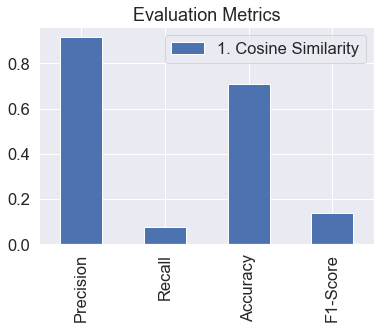

In [23]:
scores.T.plot(kind='bar',
                  title='Evaluation Metrics',
                  legend=True);

In [24]:
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

       False       0.70      1.00      0.82       325
        True       0.92      0.07      0.14       148

    accuracy                           0.71       473
   macro avg       0.81      0.54      0.48       473
weighted avg       0.77      0.71      0.61       473



In [25]:
# Algorithm-2-a: Fuzzy Matching with ratio
# Algorithm-2-b: Fuzzy Matching with token sort ratio

# ratio - metric for similarity - simple ratio 
# partial ratio - part of string to be found or searched while checking parial ratio
# token sort ratio - sort words and then see occurences

# Set a threshold based on similarity percentages and mark as paraphrase or not
# 60%


fuzzy_ratios_a = []
fuzzy_ratios_b = []

for index,row in dev_df.iterrows():
    fuzzy_ratios_a.append(fuzz.ratio(row["Sent_1"], row["Sent_2"]))
    fuzzy_ratios_b.append(fuzz.token_sort_ratio(row["Sent_1"], row["Sent_2"]))
    
dev_df["Algo_2_a_Similarities"] = fuzzy_ratios_a
dev_df["Algo_2_b_Similarities"] = fuzzy_ratios_b


dev_df['Algo_2_a'] = dev_df["Algo_2_a_Similarities"]>60
dev_df['Algo_2_b'] = dev_df["Algo_2_b_Similarities"]>60

In [26]:
fuzz.ratio("I can listen to pandora again yay", "My Pandora time out is over")

33

In [27]:
fuzz.token_sort_ratio("I can listen to pandora again yay", "My Pandora time out is over")

47

In [28]:
dev_df.head()

,Topic_Id,Topic_Names,Sent_1,Sent_2,Label,Sent_1_tag,Sent_2_tag,Cosine_Similarities,Algo_1,Algo_2_a_Similarities,Algo_2_b_Similarities,Algo_2_a,Algo_2_b
3965,1422,Ryu,Ryu is just something else,and that makes it 8 whiffs for Ryu,False,Ryu/O/NNP/B-NP/O is/O/VBZ/B-VP/O just/O/RB/B-N...,and/O/NNS/O/O that/O/WDT/B-NP/O makes/O/VBZ/B-...,0.29,False,10,37,False,False
2917,912,Kris Kross,Just read about Mac Daddy Chris Kelly of Kris ...,Bout to put my clothes on backwards in remembr...,False,Just/O/RB/B-ADVP/O read/O/VBN/B-VP/B-EVENT abo...,Bout/O/NN/B-NP/O to/O/TO/B-VP/O put/O/VB/I-VP/...,0.50,False,47,59,False,False
1741,641,Harding,Way to go Josh Harding,I feel bad for Josh Harding played a great game,True,Way/O/NN/B-NP/O to/O/TO/B-VP/O go/O/VB/I-VP/B-...,I/O/PRP/B-NP/O feel/O/VBP/B-VP/B-EVENT bad/O/J...,0.38,False,46,49,False,False
2978,913,Kriss Kross,damn Chris Kelly of Kriss Kross at 34,Damn its sad to hear about Chris Kelly from Kr...,True,damn/O/UH/B-INTJ/O Chris/B-person/NNP/B-NP/O K...,Damn/O/RB/B-ADVP/O its/O/PRP/B-NP/O sad/O/JJ/B...,0.82,True,64,66,True,True
1498,503,Facebook,I posted 6 photos on Facebook in the album Zum...,How to end a group chat on facebook,False,I/O/PRP/B-NP/O posted/O/VBD/B-VP/B-EVENT 6/O/C...,How/O/WRB/B-ADVP/O to/O/TO/B-VP/O end/O/VB/I-V...,0.20,False,46,44,False,False


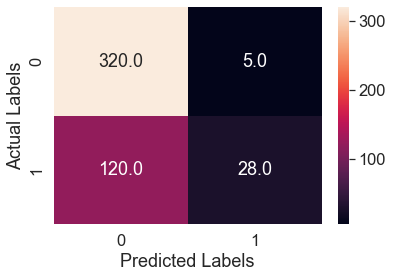

In [29]:
# ALGORITHM-2-a evaluation

actual = dev_df["Label"]
predicted = dev_df["Algo_2_a"]
plot_conf_mat(y_test=actual, y_preds=predicted)

In [30]:
# Add to scores dictionary
algo_2_a_scores = {
    'Precision': precision_score(actual, predicted),
    'Recall': recall_score(actual, predicted),
    'Accuracy': accuracy_score(actual, predicted),
    'F1-Score': f1_score(actual, predicted)
}

scores = scores.append(algo_2_a_scores, ignore_index=True)

In [31]:
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

       False       0.73      0.98      0.84       325
        True       0.85      0.19      0.31       148

    accuracy                           0.74       473
   macro avg       0.79      0.59      0.57       473
weighted avg       0.77      0.74      0.67       473



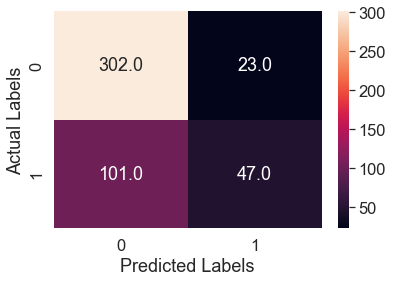

In [32]:
# ALGORITHM-2-b evaluation

actual = dev_df["Label"]
predicted = dev_df["Algo_2_b"]
plot_conf_mat(y_test=actual, y_preds=predicted)

In [33]:
# Add to scores dictionary
algo_2_b_scores = {
    'Precision': precision_score(actual, predicted),
    'Recall': recall_score(actual, predicted),
    'Accuracy': accuracy_score(actual, predicted),
    'F1-Score': f1_score(actual, predicted)
}


In [34]:
scores = scores.append(algo_2_b_scores, ignore_index=True)

In [35]:
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

       False       0.75      0.93      0.83       325
        True       0.67      0.32      0.43       148

    accuracy                           0.74       473
   macro avg       0.71      0.62      0.63       473
weighted avg       0.72      0.74      0.70       473



In [36]:
scores

,Precision,Recall,Accuracy,F1-Score
0,0.916667,0.074324,0.708245,0.137500
1,0.848485,0.189189,0.735729,0.309392
2,0.671429,0.317568,0.737844,0.431193


In [37]:
scores = scores.rename(index = {0: 'Cosine Similarity',
                               1: 'Fuzzy Ratio',
                               2: 'Fuzzy Token-Sort-Ratio'})

scores

,Precision,Recall,Accuracy,F1-Score
Cosine Similarity,0.916667,0.074324,0.708245,0.137500
Fuzzy Ratio,0.848485,0.189189,0.735729,0.309392
Fuzzy Token-Sort-Ratio,0.671429,0.317568,0.737844,0.431193


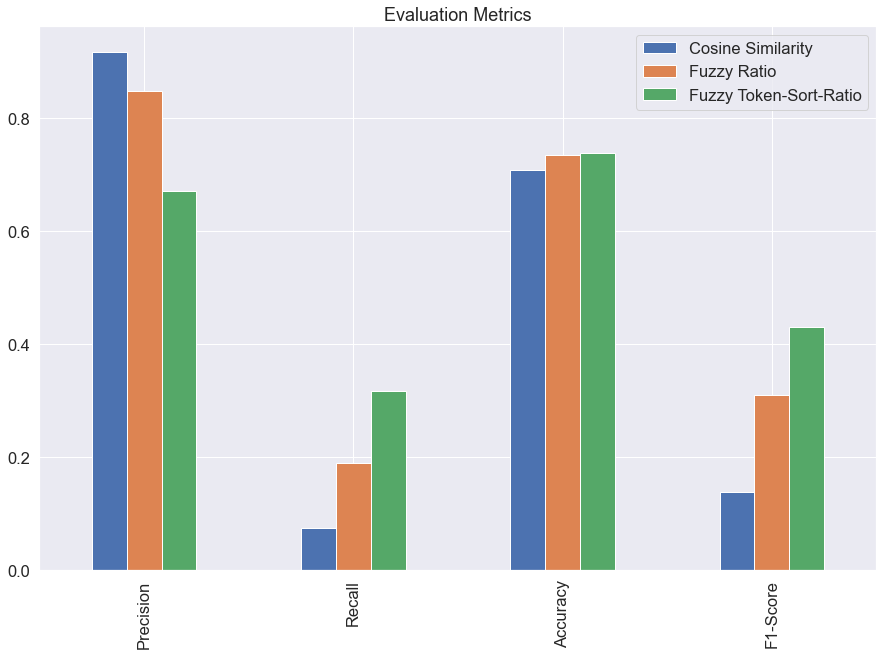

In [38]:
# Plotting all evaluation metrics for 3 algorithms together
scores.T.plot(kind='bar',
              title='Evaluation Metrics',
              legend=True,
              figsize=(15,10)
             );

In [39]:
# Picking best method as Fuzzy token-sort-ratio and apply on Test Data

In [40]:
test_df.head()

,Topic_Id,Topic_Names,Sent_1,Sent_2,Label,Sent_1_tag,Sent_2_tag
0,51,8 Mile,All the home alones watching 8 mile,8 mile is on thats my movie,3,All/O/DT/B-NP/O the/O/DT/I-NP/O home/O/NN/I-NP...,8/O/NN/B-NP/O mile/O/NN/I-NP/O is/O/VBZ/B-VP/O...
1,51,8 Mile,All the home alones watching 8 mile,The last rap battle in 8 Mile nevr gets old ahah,2,All/O/DT/B-NP/O the/O/DT/I-NP/O home/O/NN/I-NP...,The/O/DT/B-NP/O last/O/JJ/I-NP/O rap/O/NN/I-NP...
2,51,8 Mile,All the home alones watching 8 mile,The rap battle at the end of 8 mile gets me so...,2,All/O/DT/B-NP/O the/O/DT/I-NP/O home/O/NN/I-NP...,The/O/DT/B-NP/O rap/O/NN/I-NP/O battle/O/NN/I-...
3,51,8 Mile,The Ending to 8 Mile is my fav part of the who...,Rabbit on 8 mile out of place but determined t...,1,The/O/DT/B-NP/O Ending/O/VBG/I-NP/B-EVENT to/O...,Rabbit/O/NNP/B-NP/O on/O/IN/B-PP/O 8/O/CD/B-NP...
4,51,8 Mile,The Ending to 8 Mile is my fav part of the who...,See 8 Mile is always on but it s the tv versio...,1,The/O/DT/B-NP/O Ending/O/VBG/I-NP/B-EVENT to/O...,See/O/VB/B-VP/O 8/O/CD/B-NP/O Mile/O/NNP/I-NP/...


In [41]:
# Map given test labels to binary values
test_df['Actual'] = test_df['Label']>=3

In [42]:
test_df.head()

,Topic_Id,Topic_Names,Sent_1,Sent_2,Label,Sent_1_tag,Sent_2_tag,Actual
0,51,8 Mile,All the home alones watching 8 mile,8 mile is on thats my movie,3,All/O/DT/B-NP/O the/O/DT/I-NP/O home/O/NN/I-NP...,8/O/NN/B-NP/O mile/O/NN/I-NP/O is/O/VBZ/B-VP/O...,True
1,51,8 Mile,All the home alones watching 8 mile,The last rap battle in 8 Mile nevr gets old ahah,2,All/O/DT/B-NP/O the/O/DT/I-NP/O home/O/NN/I-NP...,The/O/DT/B-NP/O last/O/JJ/I-NP/O rap/O/NN/I-NP...,False
2,51,8 Mile,All the home alones watching 8 mile,The rap battle at the end of 8 mile gets me so...,2,All/O/DT/B-NP/O the/O/DT/I-NP/O home/O/NN/I-NP...,The/O/DT/B-NP/O rap/O/NN/I-NP/O battle/O/NN/I-...,False
3,51,8 Mile,The Ending to 8 Mile is my fav part of the who...,Rabbit on 8 mile out of place but determined t...,1,The/O/DT/B-NP/O Ending/O/VBG/I-NP/B-EVENT to/O...,Rabbit/O/NNP/B-NP/O on/O/IN/B-PP/O 8/O/CD/B-NP...,False
4,51,8 Mile,The Ending to 8 Mile is my fav part of the who...,See 8 Mile is always on but it s the tv versio...,1,The/O/DT/B-NP/O Ending/O/VBG/I-NP/B-EVENT to/O...,See/O/VB/B-VP/O 8/O/CD/B-NP/O Mile/O/NNP/I-NP/...,False


In [43]:
fuzzy_ratios = []

for index,row in test_df.iterrows():
    fuzzy_ratios.append(fuzz.ratio(row["Sent_1"], row["Sent_2"]))
    
test_df["Similarities"] = fuzzy_ratios

test_df["Predicted"] = test_df["Similarities"]>60

In [51]:
# see all actual tests as TRUE

test_df[test_df["Predicted"]==True]

,Topic_Id,Topic_Names,Sent_1,Sent_2,Label,Sent_1_tag,Sent_2_tag,Actual,Similarities,Predicted
27,51,8 Mile,Ok good the end of 8 Mile is on,The end of 8 Mile makes me so happy,4,Ok/O/UH/B-INTJ/O good/O/RB/I-INTJ/O the/O/DT/B...,The/O/DT/B-NP/O end/O/NN/I-NP/O of/O/IN/B-PP/O...,True,61,True
34,128,After Earth,Anyone trying to see After Earth sometime soon,Me and my son went to see After Earth last night,2,Anyone/O/NN/B-NP/O trying/O/VBG/B-VP/B-EVENT t...,Me/O/PRP/B-NP/O and/O/CC/O/O my/O/PRP$/B-NP/O ...,False,62,True
55,128,After Earth,Who wants to take me to see After Earth,Finally in the theaters to see after earth,3,Who/O/WP/B-NP/O wants/O/VBZ/B-VP/O to/O/TO/I-V...,Finally/O/RB/B-ADVP/O in/O/IN/B-PP/O the/O/DT/...,True,62,True
107,423,Big 12,Kansas just won the Big 12 championship again,Did kU win the Big 12 Quidditch Championship,4,Kansas/B-person/NNP/B-NP/O just/O/RB/B-ADVP/O ...,Did/O/VBD/B-NP/O kU/O/MD/B-VP/O win/O/VB/I-VP/...,True,63,True
168,695,Chalmers,The fuck Chalmers is doing,The fuck Chalmers is doing,5,The/B-movie/DT/B-NP/O fuck/I-movie/NNP/I-NP/O ...,The/B-band/DT/B-NP/O fuck/I-band/NNP/I-NP/O Ch...,True,100,True
...,...,...,...,...,...,...,...,...,...,...
914,4937,Udonis Haslem,Udonis Haslem has the ugliest jumper,Udonis Haslem is a disgusting human being,2,Udonis/B-person/NNP/B-NP/O Haslem/I-person/NNP...,Udonis/B-person/NNP/B-NP/O Haslem/I-person/NNP...,False,62,True
916,4937,Udonis Haslem,And passing the fire on to Udonis Haslem,Three outlet passes to Udonis Haslem,3,And/O/CC/O/O passing/O/VBG/B-VP/B-EVENT the/O/...,Three/O/DT/B-NP/O outlet/O/NN/I-NP/O passes/O/...,True,61,True
921,5211,World of Jenks,World of Jenks is one of the best shows on TV,World of Jenks is my favorite show on tv,4,World/O/NN/B-NP/O of/O/IN/B-PP/O Jenks/B-perso...,World/B-tvshow/NN/B-NP/O of/I-tvshow/IN/B-PP/O...,True,68,True
926,5211,World of Jenks,Chad from world of Jenks is the absolute cutest,Chad from World of Jenks is so adorable,5,Chad/B-person/NNP/B-NP/O from/O/IN/B-PP/O worl...,Chad/B-person/NNP/B-NP/O from/O/IN/B-PP/O Worl...,True,74,True


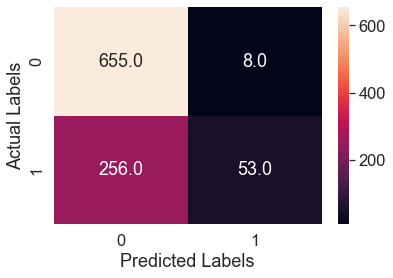

In [45]:
# Evaluation on Test Data

actual = test_df["Actual"]
predicted = test_df["Predicted"]
plot_conf_mat(y_test=actual, y_preds=predicted)

In [46]:
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

       False       0.72      0.99      0.83       663
        True       0.87      0.17      0.29       309

    accuracy                           0.73       972
   macro avg       0.79      0.58      0.56       972
weighted avg       0.77      0.73      0.66       972



In [47]:
# Create a scores dictionary
test_scores = pd.DataFrame({
    'Precision': precision_score(actual, predicted),
    'Recall': recall_score(actual, predicted),
    'Accuracy': accuracy_score(actual, predicted),
    'F1-Score': f1_score(actual, predicted)
}, index = ['Fuzzy Token-with-Ratio'])


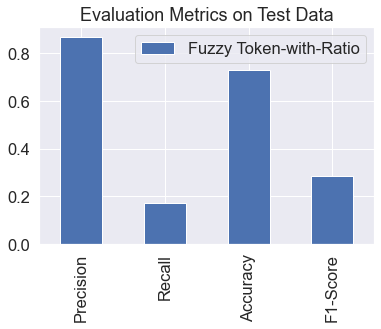

In [48]:
test_scores.T.plot(kind='bar',
                  title='Evaluation Metrics on Test Data',
                  legend=True);

In [49]:
display(test_scores)

,Precision,Recall,Accuracy,F1-Score
Fuzzy Token-with-Ratio,0.868852,0.171521,0.728395,0.286486
